# 作業1 : 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

請幫幫資料集作者完成他女朋友的挑戰。**訓練一個CNN模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**


>**作業說明**

**第一步驟**: 左上角 檔案->在雲端硬碟建立副本。

**第二步驟**: 右上角 共用->取得連結->任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段->更變執行類型->GPU。 可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個colab的程式來完成訓練CNN模型。**只要跑得出來Testing Accuracy、Loss; 1~7個作業項目即可**，不必一定要照著todo提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的label不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看test data
2. 模型請手刻、手疊，**不要用Transfer Learning**來引入ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存output結果，更改**檔名學號**，左上角 檔案->下載 成ipynb檔。
2. 交一個pdf檔，裡面需要附上**你的作業colab連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 文件內至少應貼上你的Test Acc
4. 上述兩個檔案繳交至ee-class。

> **繳交期限**

1. 電子商務技術(IM5002): 期限至2022/5/2(一) 23:59分
2. 人工智慧與機器學習(IM3078): 期限至2022/5/2(一) 23:59分
3. 電子商務智慧技術(IMA0200): 期限至2022/4/23(六) 23:59分

> **算分標準**

20 + Test_Acc + Predict function(10分) + 20分文件
1. 20分免費送
2. Test_Acc
3. preditAuthor有寫出來就10分(第七段)
4. 20分是文件分數

有問題再來信助教: ncuzhonghuan@g.ncu.edu.tw

### 資料集下載

- 資料集說明 : 
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊colab左側**檔案**來查看

In [ ]:
# import random
# import os 

# # 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# # 以節省學術網路資源，避免IP被封鎖

# if(os.path.isfile("./train.zip") == False):
#   !wget -O train.zip "http://140.115.83.111/files/art/train.zip"
#   !wget -O test.zip "http://140.115.83.111/files/art/test.zip"
#   !echo "分流1"
#   !unzip train.zip
#   !unzip test.zip 
# else:
#   !echo "檔案已存在"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/train/

artists.csv  train_resized


## 1. 讀入封包

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random

## 2. 取得資料集

- **我們來檢視一下artist.csv**，重要內容包含:
  - 畫家名稱(name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有50位畫家，意味者有50個class要去辨識。

In [4]:
root ='drive/MyDrive'
train_dir = root + "/train/train_resized/"
test_dir = root + "/test_resized/"
artists = pd.read_csv(root + "/train/artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ",num_classes)
artists.head()

Number of artists :  50


,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: ?а?и?...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod m?n?]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [??ne...,http://en.wikipedia.org/wiki/René_Magritte,194


* 只取出名字與畫的數量，把名字用下底線連起來

In [5]:
artists = artists.loc[:,["name","paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

,name,paintings
0,Amedeo_Modigliani,193
1,Vasiliy_Kandinskiy,88
2,Diego_Rivera,70
3,Claude_Monet,73
4,Rene_Magritte,194


* **計算各個畫家畫作數量**
* 每個class資料的不平衡容易引響模型的訓練，學生可以嘗試解決這個問題。(提示: keras的class_weight)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24


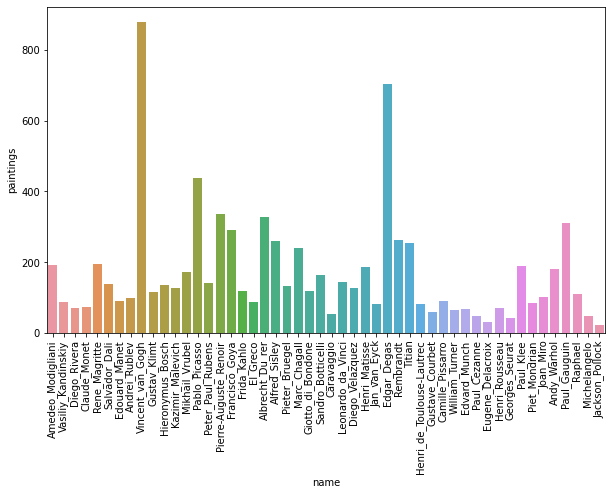

In [6]:
%matplotlib inline
plt.figure(figsize=(10, 6))
barplot = sns.barplot(artists.name,artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)
    
print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ",artists.paintings.max()," 最少畫作為 : ",artists.paintings.min())

* 隨機讀取畫作來看看

training 畫作總共畫作有 :  7664


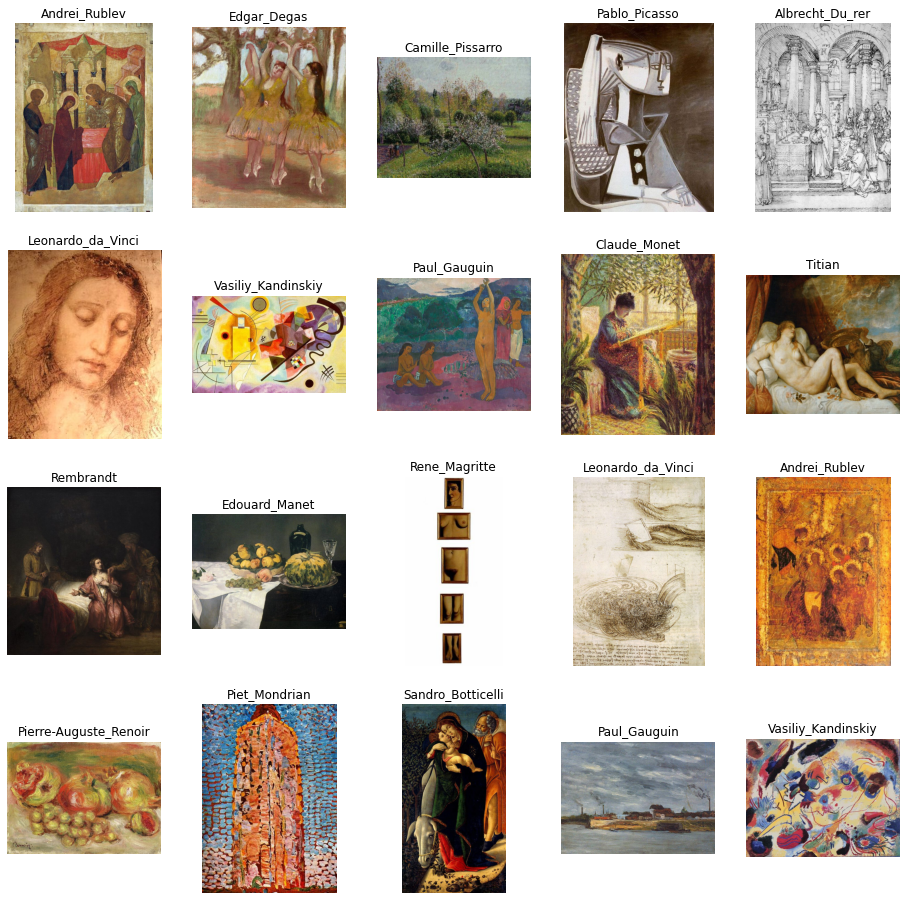

In [21]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
randomlist = random.sample(range(0,total_len), 20)
print("training 畫作總共畫作有 : ",total_len)

show_imgs = [img_list[rand] for rand in randomlist]

plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
    imgpath = train_dir+imgName
    img = cv.imread(imgpath)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.subplot(4,5,index+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

## 3. 資料前處理

**有幾個重要的點需要處理**
1. 我們現在只有各個畫的路徑。Ex: /content/train_resized/Claude_Monet_22.jpg 。要取出label : Claude_Monet
2. label(作者名稱)是英文，我們要先把英文映射成數字。EX: Van_Gogh --> 0 ; Edvard_Munch --> 1
3. label數字還要轉乘 50 depth的one_hot
4. 現在有畫的路徑了，要讀取圖片
5. 每張圖片的大小不一樣，要統一大小才能輸入模型
6. 把每張圖片正規化，映射到[0,1]之間
7. 路徑是按照作者名稱排列的，太整齊了，把資料集打散(shuffle)。
8. 如果有需要，拆分成訓練用資料(training_data)、驗證用(validation_data)
9. **重要!** 確定好你資料input output的維度，才能開始建立模型。EX: input:(256,256,3); output:(50,)

**助教推薦一個好用的工具** from_tensor_slices [參考](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

* from_tensor_slices 可以輕鬆的讀取想要的資料，把圖片路徑傳入tensor後用map將路徑轉成圖片檔案。

* **以下程式todo只是提供程式思路，你完全可以不理他，反正test結果能出來就好。**



In [7]:
# 請建立將英文映射成數字的dict。EX: Van_Gogh --> 0
def make_Authordict():
  ##########
  # todo #
  ##########
  length=len(artists.name)
  artist_dict={}
  for i in range(length):
    artist_dict[artists.name[i]]=i
  
  return artist_dict



# 請建立將數字映射成英文的dict。 EX: 0 --> Van_Gogh

artist_dict=make_Authordict()
print(artist_dict)

rev_class_name={v: k for k, v in artist_dict.items()}
print(rev_class_name)

{'Amedeo_Modigliani': 0, 'Vasiliy_Kandinskiy': 1, 'Diego_Rivera': 2, 'Claude_Monet': 3, 'Rene_Magritte': 4, 'Salvador_Dali': 5, 'Edouard_Manet': 6, 'Andrei_Rublev': 7, 'Vincent_van_Gogh': 8, 'Gustav_Klimt': 9, 'Hieronymus_Bosch': 10, 'Kazimir_Malevich': 11, 'Mikhail_Vrubel': 12, 'Pablo_Picasso': 13, 'Peter_Paul_Rubens': 14, 'Pierre-Auguste_Renoir': 15, 'Francisco_Goya': 16, 'Frida_Kahlo': 17, 'El_Greco': 18, 'Albrecht_Du_rer': 19, 'Alfred_Sisley': 20, 'Pieter_Bruegel': 21, 'Marc_Chagall': 22, 'Giotto_di_Bondone': 23, 'Sandro_Botticelli': 24, 'Caravaggio': 25, 'Leonardo_da_Vinci': 26, 'Diego_Velazquez': 27, 'Henri_Matisse': 28, 'Jan_van_Eyck': 29, 'Edgar_Degas': 30, 'Rembrandt': 31, 'Titian': 32, 'Henri_de_Toulouse-Lautrec': 33, 'Gustave_Courbet': 34, 'Camille_Pissarro': 35, 'William_Turner': 36, 'Edvard_Munch': 37, 'Paul_Cezanne': 38, 'Eugene_Delacroix': 39, 'Henri_Rousseau': 40, 'Georges_Seurat': 41, 'Paul_Klee': 42, 'Piet_Mondrian': 43, 'Joan_Miro': 44, 'Andy_Warhol': 45, 'Paul_Gaugu

In [8]:
def get_label(picName):
  # 請取出label並轉成數字
  # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
  ##########
  # todo #
  ##########
  picName = picName.split('_')
  name_lst= []
  name= ''
  for i in picName:
    if 'jpg' not in i:
      name_lst.append(i)
  for j in name_lst:
    name=name+j+'_'
  
  if name[:-1]=='Albrecht_Du_rer':
    label=19
  else:
    label=artist_dict[name[:-1]]

  return label

def get_path(dir,picName):
  # 請將路徑合併
  # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg
  ##########
  # todo #
  ##########
  dir_path=dir+picName
  return dir_path

def make_paths_label(dir):
  # 將preprocess完成的path、label用for迴圈放入paths和labels
  ##########
  # todo #
  ##########
  img_list = os.listdir(dir)
  paths = []
  labels = []
  length=len(img_list)
  for i in range(length):
    path=get_path(dir,img_list[i])
    paths.append(path)
    label=get_label(img_list[i])
    labels.append(label)

 # 將labels轉成onehot
  # todo
  onehot_labels = keras.utils.to_categorical(labels, num_classes)
  return paths,onehot_labels




In [9]:
# train_dir='/content/drive/MyDrive/picture_train/train_resized/'
# test_dir='/content/drive/MyDrive/picture_train/test_resized/'

# 來查看一下
paths,onehot_labels = make_paths_label(train_dir)

print("paths : ")
for p in paths[:5]:
  print(p)
print("-"*20)
print("labels : ")
for label in onehot_labels[:5]:
  print(label)

paths : 
drive/MyDrive/train/train_resized/Titian_149.jpg
drive/MyDrive/train/train_resized/Titian_224.jpg
drive/MyDrive/train/train_resized/Titian_209.jpg
drive/MyDrive/train/train_resized/Titian_237.jpg
drive/MyDrive/train/train_resized/Titian_182.jpg
--------------------
labels : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [ ]:
# # 轉成tensorflow dataset格式，變成路徑tensor
# # 這個只是from_tensor_slices範例
# paths_ds = tf.data.Dataset.from_tensor_slices(paths)
# train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

# print("turn to tensor")
# for tensor in paths_ds.take(5):
#   print(tensor)

In [10]:
# 決定你輸入模型的圖片長寬
# shuffle buffle size
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_SIZE = None
shuffle_buffer = 7500

def get_image(path):
  # read image from path
  file = tf.io.read_file(path)
  img = tf.io.decode_jpeg(file,channels=3)
  img = tf.cast(img,tf.float32)

  # 請固定每張圖片大小為IMG_HEIGHT、IMG_WIDTH
  # 並將圖片每個pixel映射到[0,1]之間
  ##########
  # todo #
  ##########
  img = tf.image.resize(img,[IMG_WIDTH , IMG_HEIGHT])
  img = img / 255.0

  return img

# 將所有資料轉成Tensor -> Tensor 轉成圖片
# 圖片Tensor 與 label Tensor Zip起來成一個pair
# shuffle打散
def make_dataset(dir):
  paths,onehot_labels = make_paths_label(dir)
  paths_ds = tf.data.Dataset.from_tensor_slices(paths)
  print(paths_ds)
  train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)
  print(train_label)

  # 將路徑tensor映射成圖片tensor 
  train_image = paths_ds.map(get_image)
  # 合併圖片與label資料集
  full_ds = tf.data.Dataset.zip((train_image,train_label))
  # 打散
  full_ds = full_ds.shuffle(shuffle_buffer,reshuffle_each_iteration=False)
  return full_ds

full_ds = make_dataset(train_dir)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TensorSliceDataset element_spec=TensorSpec(shape=(50,), dtype=tf.float32, name=None)>


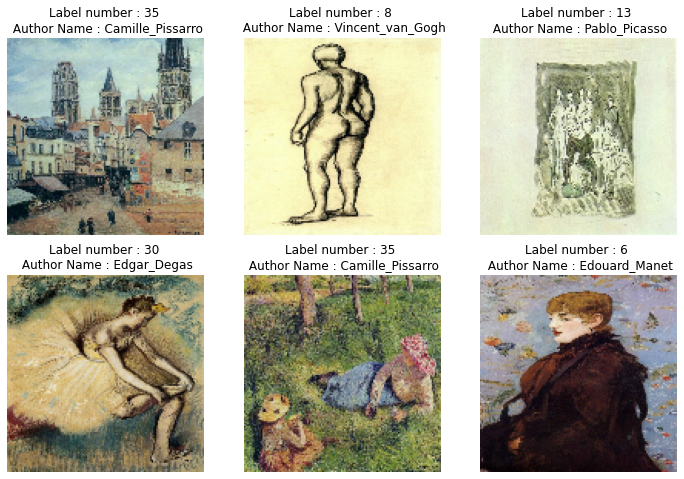

In [ ]:
# 取出Tensor圖片來看看
plt.figure(figsize=(12, 8))
for index,(img,label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2,3,index+1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(
        l,
        rev_class_name[l]))
    plt.axis("off")

In [ ]:
len(full_ds)

7664

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [11]:
# 切割成training data與validation data
total_len=len(full_ds)
train_len = int(0.8*total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ",train_len," val size : ",val_len)

# 添加batch
# todo
batch_size = 16

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train size :  6131  val size :  1533


In [ ]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x,y = trainiter.next()
print("training image batch shape : ",x.shape)
print("training label batch shape : ",y.shape)

training image batch shape :  (16, 128, 128, 3)
training label batch shape :  (16, 50)


Data Argumentation

Visualise data augmentation

## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做fine-tuning，**請自己手動建**。

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [13]:
input_shape = (128, 128, 3)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),  
        data_augmentation,
        #layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)            

In [ ]:
1e-3*10**(1/30),1e-3*10**(20/30)

(0.0010797751623277097, 0.004641588833612778)

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [14]:
# opti = tf.keras.optimizers.RMSprop(momentum=0.5)

epochs = 40

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/40
384/384 [==============================] - 147s 92ms/step - loss: 3.4770 - accuracy: 0.1362 - val_loss: 3.2338 - val_accuracy: 0.1670
Epoch 2/40
384/384 [==============================] - 62s 92ms/step - loss: 3.1224 - accuracy: 0.2026 - val_loss: 3.0841 - val_accuracy: 0.2127
Epoch 3/40
384/384 [==============================] - 62s 92ms/step - loss: 2.9745 - accuracy: 0.2288 - val_loss: 2.9110 - val_accuracy: 0.2453
Epoch 4/40
384/384 [==============================] - 62s 92ms/step - loss: 2.8965 - accuracy: 0.2437 - val_loss: 2.9047 - val_accuracy: 0.2414
Epoch 5/40
384/384 [==============================] - 62s 92ms/step - loss: 2.7921 - accuracy: 0.2677 - val_loss: 2.9218 - val_accuracy: 0.2303
Epoch 6/40
384/384 [==============================] - 63s 93ms/step - loss: 2.7261 - accuracy: 0.2791 - val_loss: 2.9083 - val_accuracy: 0.2420
Epoch 7/40
384/384 [==============================] - 67s 92ms/step - loss: 2.6729 - accuracy: 0.2913 - val_loss: 2.7556 - val_accuracy

In [ ]:
# opti = tf.keras.optimizers.RMSprop(momentum=0.1)

# epochs = 10

# model.compile(loss="categorical_crossentropy", optimizer=opti, metrics=["accuracy"])

# history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/10
384/384 [==============================] - 58s 80ms/step - loss: 3.6442 - accuracy: 0.1174 - val_loss: 3.3743 - val_accuracy: 0.1768
Epoch 2/10
384/384 [==============================] - 57s 80ms/step - loss: 3.3552 - accuracy: 0.1771 - val_loss: 3.1205 - val_accuracy: 0.2127
Epoch 3/10
384/384 [==============================] - 57s 80ms/step - loss: 3.1671 - accuracy: 0.2080 - val_loss: 3.0349 - val_accuracy: 0.2440
Epoch 4/10
384/384 [==============================] - 57s 81ms/step - loss: 2.9844 - accuracy: 0.2486 - val_loss: 2.9235 - val_accuracy: 0.2661
Epoch 5/10
384/384 [==============================] - 57s 80ms/step - loss: 2.8499 - accuracy: 0.2667 - val_loss: 2.8447 - val_accuracy: 0.2668
Epoch 6/10
384/384 [==============================] - 57s 80ms/step - loss: 2.7414 - accuracy: 0.2924 - val_loss: 2.8477 - val_accuracy: 0.2825
Epoch 7/10
384/384 [==============================] - 57s 80ms/step - loss: 2.5884 - accuracy: 0.3324 - val_loss: 2.7863 - val_accuracy:

In [ ]:
# # opti = tf.keras.optimizers.RMSprop(momentum=0.5)

# epochs = 25

# model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/25
384/384 [==============================] - 106s 177ms/step - loss: 3.5704 - accuracy: 0.1214 - val_loss: 3.2297 - val_accuracy: 0.1533
Epoch 2/25
384/384 [==============================] - 90s 140ms/step - loss: 3.2020 - accuracy: 0.1913 - val_loss: 3.1527 - val_accuracy: 0.1663
Epoch 3/25
384/384 [==============================] - 90s 139ms/step - loss: 3.0351 - accuracy: 0.2151 - val_loss: 2.8596 - val_accuracy: 0.2335
Epoch 4/25
384/384 [==============================] - 91s 140ms/step - loss: 2.9331 - accuracy: 0.2300 - val_loss: 3.0145 - val_accuracy: 0.2035
Epoch 5/25
384/384 [==============================] - 92s 142ms/step - loss: 2.8661 - accuracy: 0.2456 - val_loss: 2.7594 - val_accuracy: 0.2622
Epoch 6/25
384/384 [==============================] - 92s 141ms/step - loss: 2.7985 - accuracy: 0.2544 - val_loss: 2.7707 - val_accuracy: 0.2694
Epoch 7/25
384/384 [==============================] - 92s 141ms/step - loss: 2.7433 - accuracy: 0.2753 - val_loss: 2.8075 - val_a

In [ ]:
# epochs = 5

# model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/5
384/384 [==============================] - 92s 139ms/step - loss: 2.1771 - accuracy: 0.3960 - val_loss: 2.6613 - val_accuracy: 0.3346
Epoch 2/5
384/384 [==============================] - 91s 139ms/step - loss: 2.1358 - accuracy: 0.4060 - val_loss: 2.4453 - val_accuracy: 0.3699
Epoch 3/5
384/384 [==============================] - 91s 140ms/step - loss: 2.1325 - accuracy: 0.4100 - val_loss: 2.6038 - val_accuracy: 0.3340
Epoch 4/5
384/384 [==============================] - 91s 140ms/step - loss: 2.1078 - accuracy: 0.4052 - val_loss: 2.6497 - val_accuracy: 0.3562
Epoch 5/5
384/384 [==============================] - 90s 139ms/step - loss: 2.0680 - accuracy: 0.4145 - val_loss: 2.6655 - val_accuracy: 0.3372


In [ ]:
# epochs = 5

# model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/5
384/384 [==============================] - 91s 139ms/step - loss: 2.0637 - accuracy: 0.4206 - val_loss: 2.4824 - val_accuracy: 0.3646
Epoch 2/5
384/384 [==============================] - 91s 139ms/step - loss: 2.0876 - accuracy: 0.4164 - val_loss: 2.5528 - val_accuracy: 0.3529
Epoch 3/5
384/384 [==============================] - 91s 139ms/step - loss: 2.0394 - accuracy: 0.4282 - val_loss: 2.5479 - val_accuracy: 0.3581
Epoch 4/5
384/384 [==============================] - 91s 139ms/step - loss: 2.0324 - accuracy: 0.4327 - val_loss: 2.5886 - val_accuracy: 0.3536
Epoch 5/5
384/384 [==============================] - 91s 140ms/step - loss: 2.0295 - accuracy: 0.4366 - val_loss: 2.5561 - val_accuracy: 0.3457


In [ ]:
# epochs = 5

# model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/5
384/384 [==============================] - 96s 140ms/step - loss: 2.0359 - accuracy: 0.4342 - val_loss: 2.7172 - val_accuracy: 0.3444
Epoch 2/5
384/384 [==============================] - 94s 139ms/step - loss: 2.0129 - accuracy: 0.4332 - val_loss: 2.6614 - val_accuracy: 0.3594
Epoch 3/5
384/384 [==============================] - 91s 139ms/step - loss: 2.0022 - accuracy: 0.4417 - val_loss: 2.8760 - val_accuracy: 0.3346
Epoch 4/5
384/384 [==============================] - 91s 139ms/step - loss: 1.9931 - accuracy: 0.4440 - val_loss: 2.5645 - val_accuracy: 0.3757
Epoch 5/5
384/384 [==============================] - 91s 139ms/step - loss: 1.9784 - accuracy: 0.4388 - val_loss: 2.5434 - val_accuracy: 0.3692


In [ ]:
# epochs = 5

# model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/5
384/384 [==============================] - 96s 140ms/step - loss: 1.9882 - accuracy: 0.4423 - val_loss: 2.6764 - val_accuracy: 0.3523
Epoch 2/5
384/384 [==============================] - 93s 144ms/step - loss: 1.9781 - accuracy: 0.4451 - val_loss: 2.7315 - val_accuracy: 0.3464
Epoch 3/5
384/384 [==============================] - 91s 140ms/step - loss: 1.9503 - accuracy: 0.4546 - val_loss: 2.6048 - val_accuracy: 0.3607
Epoch 4/5
384/384 [==============================] - 91s 140ms/step - loss: 1.9403 - accuracy: 0.4498 - val_loss: 2.8610 - val_accuracy: 0.3281
Epoch 5/5
384/384 [==============================] - 92s 140ms/step - loss: 1.9322 - accuracy: 0.4596 - val_loss: 2.8015 - val_accuracy: 0.3399


## 6. 評估模型

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


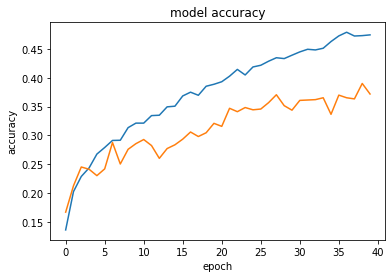

In [15]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

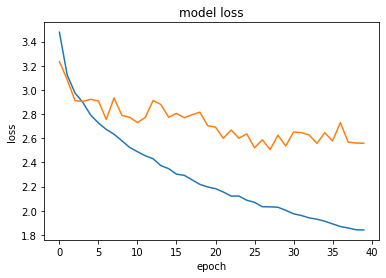

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
# # 讀入測試資料並評估模型
# test_ds = make_dataset(test_dir)
# test_ds = test_ds.batch(batch_size)
# score = model.evaluate(test_ds)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TensorSliceDataset element_spec=TensorSpec(shape=(50,), dtype=tf.float32, name=None)>
53/53 [==============================] - 18s 14ms/step - loss: 2.7430 - accuracy: 0.3449
Test loss: 2.742966651916504
Test accuracy: 0.3449101746082306


In [ ]:
# # 讀入測試資料並評估模型
# test_ds = make_dataset(test_dir)
# test_ds = test_ds.batch(batch_size)
# score = model.evaluate(test_ds)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TensorSliceDataset element_spec=TensorSpec(shape=(50,), dtype=tf.float32, name=None)>
53/53 [==============================] - 6s 14ms/step - loss: 2.9416 - accuracy: 0.3281
Test loss: 2.9415853023529053
Test accuracy: 0.3281437158584595


In [ ]:
# # 讀入測試資料並評估模型
# test_ds = make_dataset(test_dir)
# test_ds = test_ds.batch(batch_size)
# score = model.evaluate(test_ds)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TensorSliceDataset element_spec=TensorSpec(shape=(50,), dtype=tf.float32, name=None)>
53/53 [==============================] - 14s 16ms/step - loss: 2.8786 - accuracy: 0.3269
Test loss: 2.8785817623138428
Test accuracy: 0.32694610953330994


In [17]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(batch_size)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TensorSliceDataset element_spec=TensorSpec(shape=(50,), dtype=tf.float32, name=None)>
53/53 [==============================] - 10s 8ms/step - loss: 2.7750 - accuracy: 0.3473
Test loss: 2.7750003337860107
Test accuracy: 0.34730538725852966





























7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入Model做預測

In [18]:

def preditAuthor(img):
  # 寫個單圖片模型預測function
  # input : opencv img (height,width,3)
  # output : 某個作家名字 E.g. Claude_Monet
  #
  # 參考步驟:
  # 1. expand img dimension (height,width,3) -> (1,height,width,3)
  # 2. 丟入模型 model.predict
  # 3. 取出softmax後(50,) 取最大值的index作為辨識結果
  # 4. 將辨識結果轉為畫作家名字
  authorName = ""
  img=tf.reshape(img,(1,IMG_WIDTH , IMG_HEIGHT,3))
  # print(img)
  predict=model.predict(img)
  #predict.astype(int)
  #print(predict)
  predict_max=np.argmax(predict[0])
  authorName=rev_class_name[predict_max]
  
  #array=array.astype(int)
  #print(array)
  # for i in range(length):
  #     if  array[i]==1:
  #         authorName=rev_class_name[i]      
  # img = tf.expand_dims(img, axis=0)
  # print(img)
  # prediction = model.predict(img)
  # prediction_idx = np.argmax(prediction[0])
  # authorName = rev_class_name[prediction_idx]
  return  authorName

  


In [19]:
imgpath = "/content/drive/MyDrive/train/train_resized/Albrecht_Du_rer_10.jpg"
img=cv.imread(imgpath)
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
img=tf.image.resize(img,(IMG_WIDTH,IMG_HEIGHT))
img = img / 255.0

pred_author=preditAuthor(img)
#print(pred_author)
#print(type(pred_author))
pred_author

'Albrecht_Du_rer'

In [ ]:

# imgpath = "/content/drive/MyDrive/train/train_resized/Albrecht_Du_rer_10.jpg"
# img=cv.imread(imgpath)
# img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
# print(img.shape)
# #img=np.expand_dims(img,axis=0)
# #print(img)
# img=tf.image.resize(img,[IMG_WIDTH , IMG_HEIGHT])
# print(img.shape)
# img=tf.reshape(img,(1,128,128,3))
# print(img.shape)
# predict=model.predict(img)
# print(predict)
# print(type(predict))
# #predict_tolist = predict.tolist()
# #print(predict_tolist)
# #print(type(predict_tolist))
# # predict.astype(int)
# # print(predict)
# # array=print(predict[0])
# # print(array)


# #answer=tf.argmax(predict[0], axis=0)
# #print(answer)
# #print(answer[0])





In [ ]:
# predict.astype(int)
# print(predict)
# array=predict[0]
# print(array)
# array=array.astype(int)
# print(array[0])
# print(type(array[0]))



In [ ]:

# length=len(array)

# for i in range(length):
#     if  array[i]==1:
#         print(rev_class_name[i])



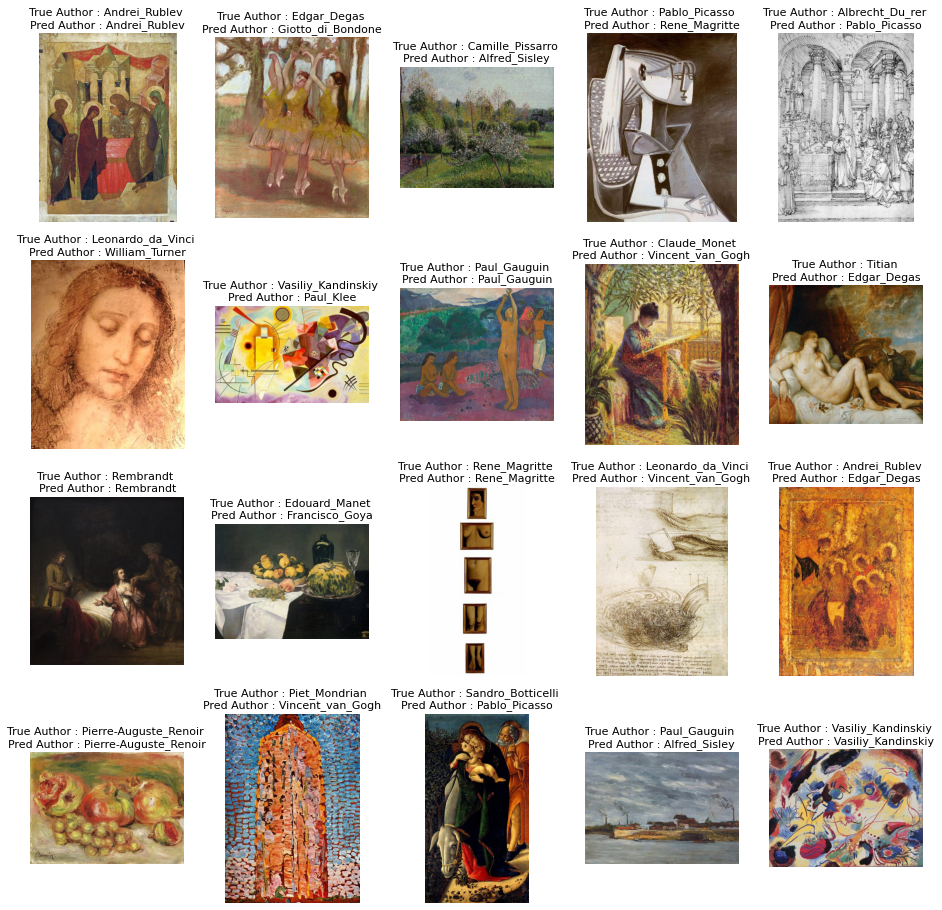

In [22]:
plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
  imgpath = train_dir+imgName
  img = cv.imread(imgpath)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.subplot(4,5,index+1)
  plt.axis("off")
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img / 255.0
  Pred_Author=preditAuthor(img)
  plt.title("True Author : {} \nPred Author : {}".format("_".join(imgName.split("_")[:-1]), Pred_Author),size=11)

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

* 自己上傳圖片來試試看模型的效果

In [23]:
from google.colab import files

def upload_img():
  uploaded = files.upload()
  img_name = list(uploaded.keys())[0]
  img = cv.imread(img_name)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img/255.0
  return img

def eval():
  img = upload_img()
  plt.title("predict author : {}".format(preditAuthor(img)))
  plt.axis("off")
  plt.show()

Saving 截圖 2022-04-09 上午11.07.20.png to 截圖 2022-04-09 上午11.07.20.png


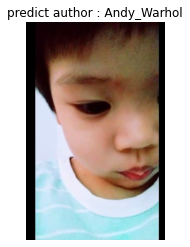

In [24]:
# 自己上傳一張圖片來試試看
# Demo圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()